# Change Point Detection

## Problem statement

In [ ]:
# install packages, donwload data

# !pip install ruptures
# !git clone https://github.com/stalex2902/cpd-seminar.git

In [1]:
# all necessary imports 
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall, hausdorff, randindex

import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/as_cpd/miniconda/envs/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Part 1: simple data and 'ruptures' package

'Ruptures' is a useful python package for CPD with the implementation of basic untrainable CPD algorithms, e.g. binary segmentation, bottom-up segmentation, PELT, kernel CPD, etc. 

In this seminar, we'll consider several illustrative cases of its usage. See the [manual](https://centre-borelli.github.io/ruptures-docs/) for the documentation and the gallery of examples.

### Synthetic data

Ruptures allow to generate simple multivariate synthetic data: piesewise-constant and piecewise-linear signals with noise, piecewise normal and piecewise sinusoidal. Let's have generate simple 1D piecewise-constant time series with 5 CPs.

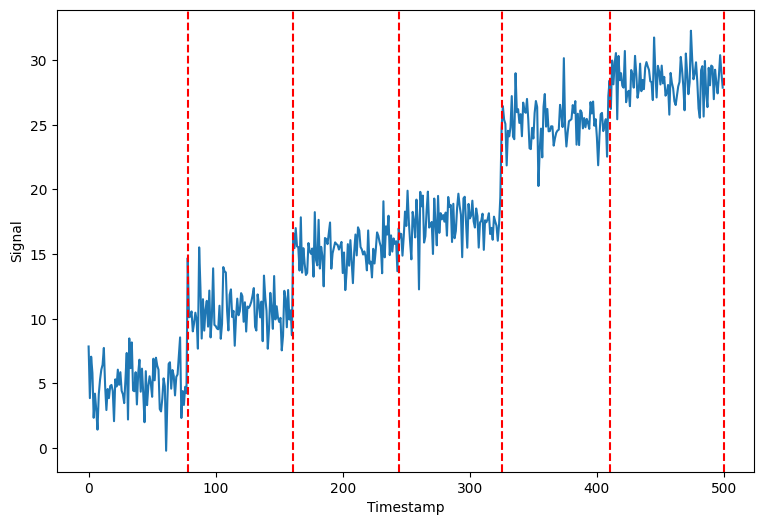

In [2]:
n_samples, n_dims, sigma = 500, 1, 1.5
n_cps = 5  # number of change points
signal, cps = rpt.pw_constant(n_samples, n_dims, n_cps, noise_std=sigma)

plt.figure(figsize=(9, 6))
plt.plot(signal)
for cp in cps:
    plt.axvline(cp, c="red", linestyle="--")
plt.xlabel("Timestamp")
plt.ylabel("Signal")
plt.show()

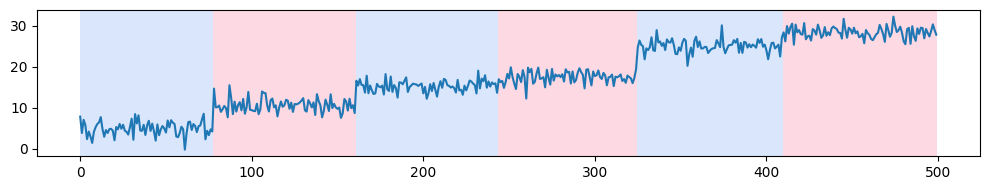

In [3]:
# built-in ruptures function for visualization
fig, ax_array = rpt.display(signal, cps)

### Simple models from ruptures

* Dynp: segmentation-based approach, uses dynamic programming for optimization
* PELT: uses cost function with penalty (see [paper](https://www.researchgate.net/publication/48180788_Optimal_Detection_of_Changepoints_With_a_Linear_Computational_Cost))
* KernelCPD: maps signal into RKHS and performs CPD there (e.g. [paper 1](https://arxiv.org/abs/1710.04556) and [paper 2](https://arxiv.org/abs/1202.3878))

See more basic methods and their details in the [manual](https://centre-borelli.github.io/ruptures-docs/user-guide/).


CPs predicted by Binseg: [80, 160, 245, 325, 410, 500]


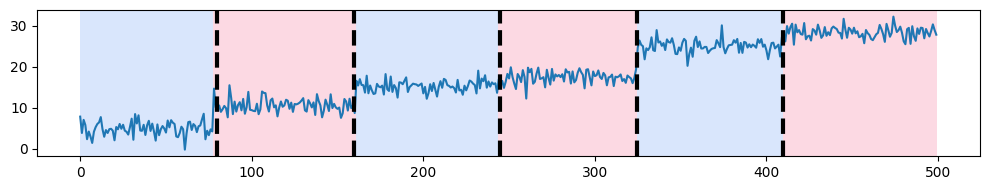

CPs predicted by Dynp: [80, 160, 245, 325, 410, 500]


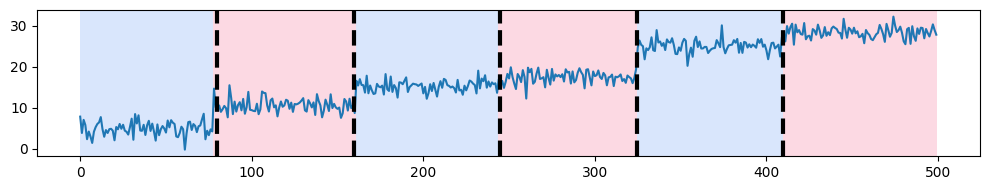

CPs predicted by PELT: [80, 160, 245, 325, 410, 500]


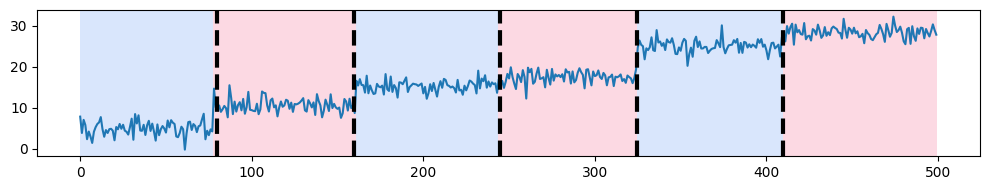

CPs predicted by KernelCPD: [78, 161, 249, 325, 409, 500]


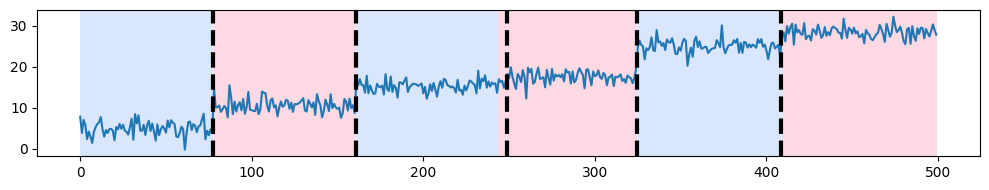

In [4]:
results_dict = dict()

algo = rpt.Binseg(model="l2").fit(signal)
result_binseg = algo.predict(n_bkps=n_cps)
results_dict["binseg"] = result_binseg 

print("CPs predicted by Binseg:", result_binseg)

rpt.display(signal, cps, result_binseg)
plt.show()
# -----------------------------------------------#

algo = rpt.Dynp(model="l2").fit(signal)
result_dynp = algo.predict(n_bkps=n_cps)
results_dict["dynp"] = result_dynp 

print("CPs predicted by Dynp:", result_dynp)

rpt.display(signal, cps, result_dynp)
plt.show()
# -----------------------------------------------#

algo = rpt.Pelt(model="l2").fit(signal)
result_pelt = algo.predict(pen=50)
results_dict["pelt"] = result_pelt 

print("CPs predicted by PELT:", result_pelt)

rpt.display(signal, cps, result_pelt)
plt.show()
# -----------------------------------------------#

algo = rpt.KernelCPD(kernel="rbf").fit(signal)
result_kernel = algo.predict(n_bkps=n_cps)
results_dict["kernel"] = result_kernel 

print("CPs predicted by KernelCPD:", result_kernel)

rpt.display(signal, cps, result_kernel)
plt.show()

### Evaluation metrics

1. Classification-based metrics (e.g. precision, recall, F1) with specific interpretation
    - Option 1:
    - Option 2:

2. Segmentation-based metrics (e.g. Hausdorff metric, Rand index, Covering score, etc.)
3. Specific CPD metrics (e.g. Detection Delay, Time for False Alarm, Area under the Detection Curve)

In ruptures, there metrics groups 1 and 2. We'll have a look at the task-specific metrics later.

In [5]:
for model, preds in results_dict.items():
    pr, rec = precision_recall(cps, preds, margin=10) # margin = 10 by default
    haus = hausdorff(cps, preds)
    rand = randindex(cps, preds)
    print(f"Model: {model}")
    print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")
    print("-" * 52)

Model: binseg
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: dynp
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: pelt
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: kernel
prec = 1.0, rec = 1.0, hausdorff = 5.0, rand = 0.99
----------------------------------------------------


We see that all the models perfectly solve this trivial CPD task. Let's have a look at

## Part 2: real 3D data

'Beedance' records the pixel locations in x and y dimensions and angle differences of bee movements. Ethologists are interested in the three-stages bee waggle dance and aim at identifying the change point from one stage to another, where different stages serve as the communication with other honey bees about the location of pollen and water. See [link](https://sites.cc.gatech.edu/~borg/ijcv_psslds/).

In [10]:
def load_data(data_path, dataset):
    data_raw = sio.loadmat(f"{data_path}/{dataset}.mat")
    
    data = data_raw['Y']                                   
    target = data_raw['L']

    if dataset == "fishkiller":
        subseq_len = 5000
        data, target = data[:subseq_len], target[:subseq_len]
        cps = list(np.where(np.diff(target.flatten()) != 0)[0])
    elif dataset == "beedance":
        cps = list(np.where(target.flatten() != 0)[0])

    cps.append(len(target))
    return data, cps

In [11]:
data, cps = load_data(data_path="data", dataset="beedance")

print("Data shape   :", data.shape)
print("Num of change points:", len(cps))

Data shape   : (1057, 3)
Num of change points: 20


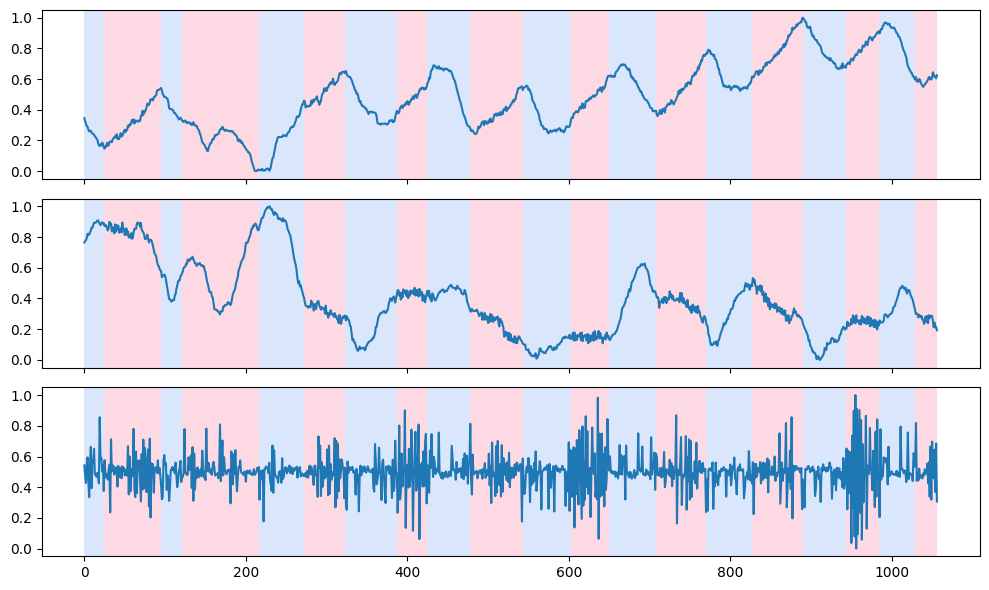

In [12]:
rpt.display(data, cps)
plt.show()

Let's use the same algorithms from ryptures for this time series as well.

CPs predicted by Binseg: [70, 90, 145, 200, 255, 270, 335, 360, 385, 470, 520, 630, 665, 700, 755, 800, 855, 970, 1010, 1025, 1057]


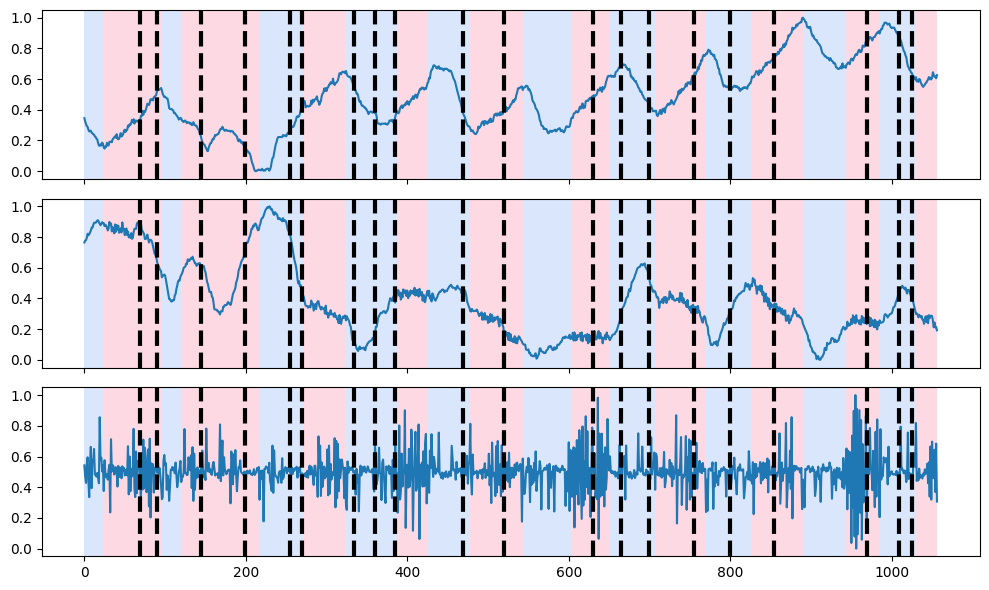

CPs predicted by Dynp: [85, 145, 195, 260, 295, 335, 365, 405, 470, 520, 560, 620, 670, 700, 750, 800, 855, 900, 955, 1020, 1057]


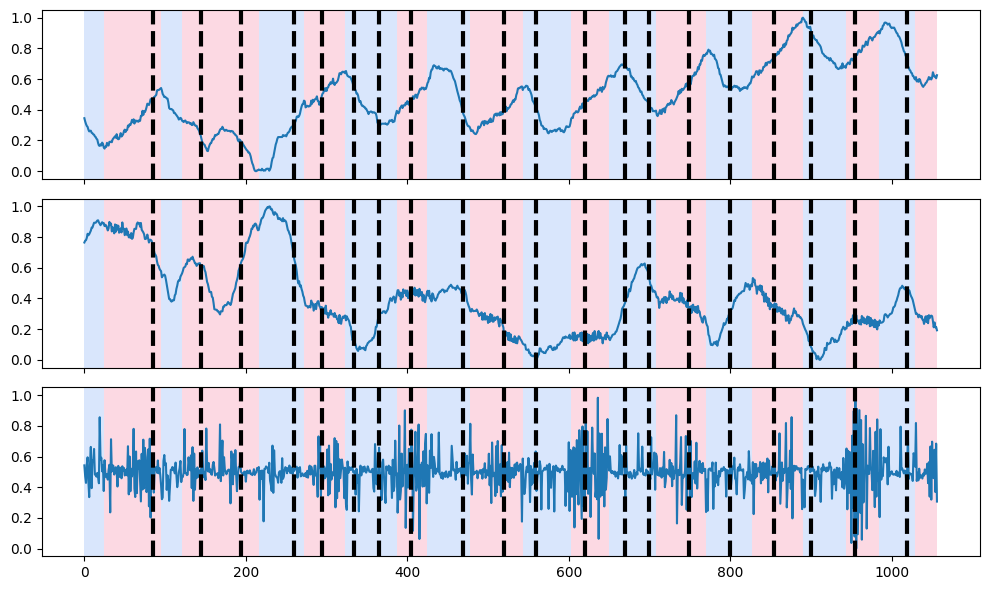

CPs predicted by PELT: [85, 145, 195, 260, 295, 335, 365, 405, 470, 520, 635, 670, 750, 800, 855, 900, 955, 1020, 1057]


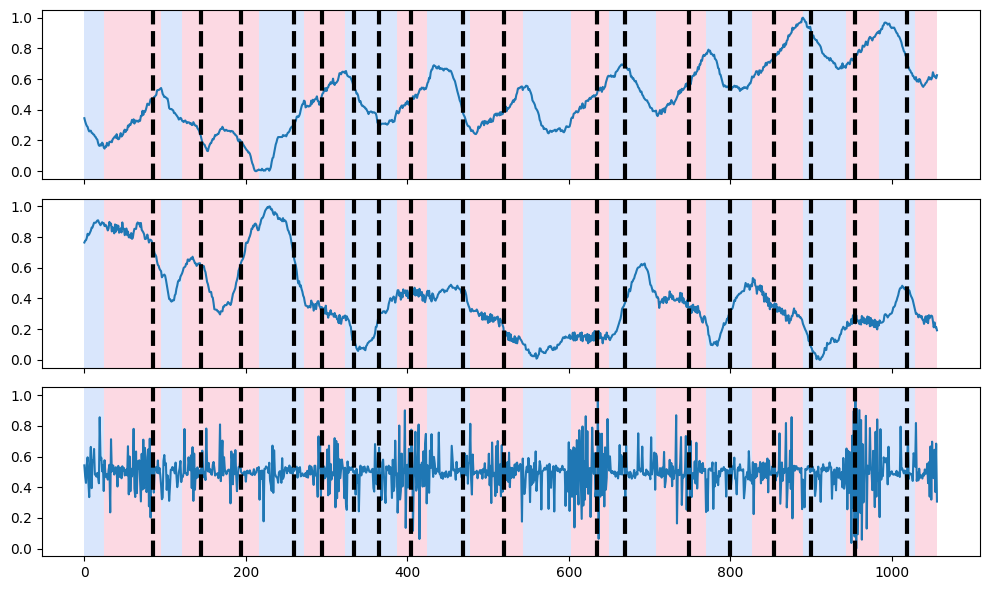

CPs predicted by KernelCPD: [84, 145, 197, 261, 295, 332, 363, 416, 467, 520, 562, 613, 666, 700, 752, 800, 858, 900, 950, 1019, 1057]


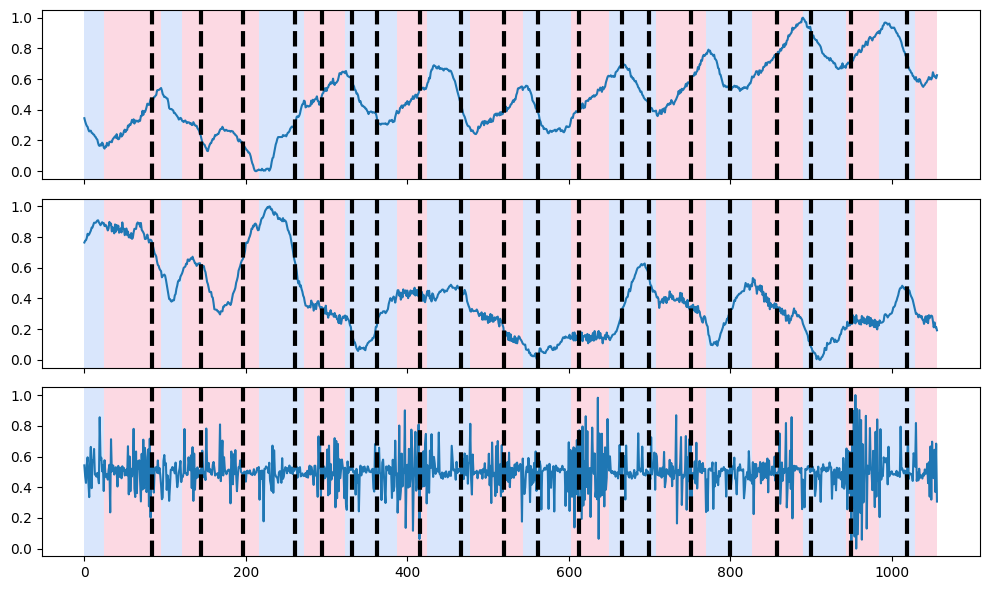

In [13]:
n_cps = len(cps)
results_dict = dict()

algo = rpt.Binseg(model="l2").fit(data)
result_binseg = algo.predict(n_bkps=n_cps)
results_dict["binseg"] = result_binseg

print("CPs predicted by Binseg:", result_binseg)

rpt.display(data, cps, result_binseg)
plt.show()
# -----------------------------------------------#

algo = rpt.Dynp(model="l2").fit(data)
result_dynp = algo.predict(n_bkps=n_cps)
results_dict["dynp"] = result_dynp 

print("CPs predicted by Dynp:", result_dynp)

rpt.display(data, cps, result_dynp)
plt.show()
# -----------------------------------------------#

algo = rpt.Pelt(model="l2").fit(data)
result_pelt = algo.predict(pen=0.7)
results_dict["pelt"] = result_pelt 

print("CPs predicted by PELT:", result_pelt)

rpt.display(data, cps, result_pelt)
plt.show()
# -----------------------------------------------#

algo = rpt.KernelCPD(kernel="rbf").fit(data)
result_kernel = algo.predict(n_bkps=n_cps)
results_dict["kernel"] = result_kernel 

print("CPs predicted by KernelCPD:", result_kernel)

rpt.display(data, cps, result_kernel)
plt.show()

In [14]:
for model, preds in results_dict.items():
    pr, rec = precision_recall(cps, preds, margin=10)
    haus = hausdorff(cps, preds)
    rand = randindex(cps, preds)
    print(f"Model: {model}")
    print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")
    print("-" * 52)

Model: binseg
prec = 0.3, rec = 0.32, hausdorff = 45.0, rand = 0.95
----------------------------------------------------
Model: dynp
prec = 0.2, rec = 0.21, hausdorff = 60.0, rand = 0.96
----------------------------------------------------
Model: pelt
prec = 0.17, rec = 0.16, hausdorff = 60.0, rand = 0.95
----------------------------------------------------
Model: kernel
prec = 0.25, rec = 0.26, hausdorff = 59.0, rand = 0.96
----------------------------------------------------


### Optimal CPD: CUSUM-statistic

Use 1D 'fishkiller' data here.

In [15]:
data, cps = load_data(data_path="data", dataset="fishkiller")

print("Data shape   :", data.shape)
print("Num of change points:", len(cps))

Data shape   : (5000, 1)
Num of change points: 11


In [28]:
def cusum_detector(series, threshold):
    normal_to_change_stat, change_to_normal_stat  = np.zeros(len(series)), np.zeros(len(series))
    normal_to_change_ind, change_to_normal_ind  = [], []
    
    all_change_idxs = []
    for i in range(1, len(series)):
        t = series[i] - series[i - 1]
        normal_to_change_stat[i] = max(0, normal_to_change_stat[i - 1] + t)
        change_to_normal_stat[i] = max(0, change_to_normal_stat[i - 1] - t)
        
        if normal_to_change_stat[i] > threshold:
            normal_to_change_ind.append(i)
            all_change_idxs.append(i)
            normal_to_change_stat[i] = 0
        if change_to_normal_stat[i] > threshold:
            change_to_normal_ind.append(i)
            all_change_idxs.append(i)
            change_to_normal_stat[i] = 0
            
    all_change_idxs.append(len(series))
        
    return all_change_idxs

In [19]:
result_cusum = cusum_detector(data, 0.09)
result_cusum

[956, 2030, 2041, 2124, 2204, 2264, 3346, 4094, 4300, 4374, 4378, 5000]

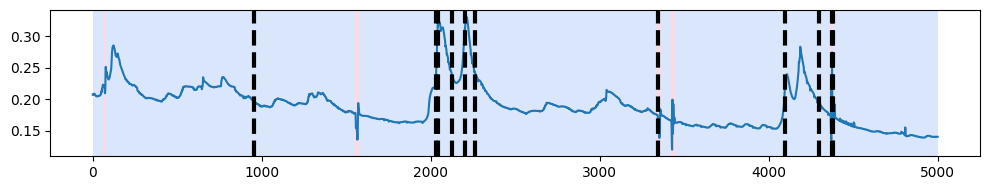

prec = 0.18, rec = 0.2, hausdorff = 888.0, rand = 0.84


In [27]:
rpt.display(data, cps, result_cusum)
plt.show()

pr, rec = precision_recall(cps, result_cusum, margin=100)
haus = hausdorff(cps, result_cusum)
rand = randindex(cps, result_cusum)

print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")

## Part 3: Neural CPD

In [ ]:
# !pip install comet-ml

In [28]:
import yaml

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from utils import datasets, metrics, core_models, cpd_models, tscp
from utils.visualize import visualize_predictions

In [29]:
SEED = 42
seed_everything(42)

Global seed set to 42


42

### Human Activity Recognition dataset

In [30]:
experiments_name = "human_activity"
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

len(train_dataset), len(test_dataset)

(3580, 1337)

### Non-trainable baselines

In [35]:
# best model for HAR is KernelCPD with 'rbf' kernel and pen=0.3

baseline_model = cpd_models.ClassicBaseline(rpt.KernelCPD(kernel="rbf"), pen=0.3)
baseline_metrics = metrics.calculate_baseline_metrics(baseline_model, test_dataloader, verbose=True, margin_list=[1, 2, 4, 6])
baseline_fp_delay, baseline_delay = baseline_metrics[1], baseline_metrics[2] 

TN: 0, FP: 663, FN: 0, TP: 674
DELAY: 0.07, FP_DELAY:5.9
F1:0.6703
COVER: 0.8538
Max F1 with margin 1: 0.7107
Max F1 with margin 2: 0.7569
Max F1 with margin 4: 0.7711
Max F1 with margin 6: 0.7868


### BCE model

In [8]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config,'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

In [11]:
core_model_bce = core_models.BaseRnn(**args_config["model"])

# define CPDModel with BCE loss
bce_model = cpd_models.CPDModel(
    loss_type="bce",
    args=args_config,
    model=core_model_bce,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)
bce_model

BaseRnn(
  (lstm): LSTM(28, 8, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=8, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [ ]:
'''
# use logger
logger = CometLogger(
    api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    project_name="cpd-seminar",
    workspace="stalex2902",
    save_dir="logs/",
    experiment_name="BCE_HAR_default"
)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    callbacks=EarlyStopping(**args_config["early_stopping"]) # use early stopping
)
trainer.fit(bce_model)

torch.save(bce_model.state_dict(), "saved_models/bce_har_default.pth")
'''

In [14]:
bce_model.load_state_dict(torch.load("saved_models/bce_har_default.pth"))

<All keys matched successfully>

In [ ]:
vis_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_batch, test_labels = next(iter(vis_dataloader))

visualize_predictions(
    bce_model,
    model_type="seq2seq",
    sequences_batch=test_batch,
    labels_batch=test_labels,
    n_pics=10
)

In [19]:
# create list of thresholds from [0, 1]
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

_, _, delay_list_bce, fp_delay_list_bce = \
    metrics.evaluation_pipeline(bce_model,
                                bce_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq",
                                margin_list=[1, 2, 4],
                               )

100%|██████████| 21/21 [00:01<00:00, 19.14it/s]


AUC: 40.6696
Time to FA 11.0524, delay detection 0.1242 for best-F1 threshold: 0.6713
TN 170, FP 11, FN 10, TP 1146 for best-F1 threshold: 0.6713
Max F1 0.9909: for best-F1 threshold 0.6713
COVER 0.9932: for best-F1 threshold 0.6713
Max COVER 0.9943: for threshold 0.8742
Max F1 with margin 1: 0.9857 for best threshold 0.7903
Max F1 with margin 2: 0.9865 for best threshold 0.7903
Max F1 with margin 4: 0.9887 for best threshold 0.6249


## TS-CP model

In [15]:
model_type = "tscp"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config,'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

In [16]:
core_model_tscp = tscp.BaseTSCPEncoder(args_config)
core_model_tscp

BaseTSCPEncoder(
  (tcn_layer): TCN(
    (residual_blocks): ModuleList(
      (0): ResidualBlock(
        (conv_1): Conv1d(28, 64, kernel_size=(5,), stride=(1,))
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (relu_1): ReLU()
        (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (relu_2): ReLU()
        (conv_block): Sequential()
        (downsample): Conv1d(28, 64, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): ResidualBlock(
        (conv_1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), dilation=(2,))
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_aff

In [17]:
tscp_model = tscp.TSCP_model(
    args_config,
    core_model_tscp,
    train_dataset,
    test_dataset
)

In [ ]:
'''
# use logger
model_name = f'tscp_har_seed_{SEED}'
logger = CometLogger(
    api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    project_name="cpd-seminar",
    workspace="stalex2902",
    save_dir="logs/",
    experiment_name="TSCP_HAR_default"
)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    # use early stopping
    callbacks=EarlyStopping(**args_config["early_stopping"])
)

trainer.fit(tscp_model)

torch.save(tscp_model.state_dict(), "saved_models/tscp_har_default.pth")
'''

In [37]:
tscp_model.load_state_dict(torch.load("saved_models/tscp_har_default.pth"))

<All keys matched successfully>

In [38]:
# create list of thresholds from [0, 1]
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

_, _, delay_list_tscp, fp_delay_list_tscp = \
    metrics.evaluation_pipeline(tscp_model,
                                tscp_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="tscp",
                                margin_list=[1, 2, 4, 6],
                                scale=args_config["predictions"]["scale"]
                               )

100%|██████████| 168/168 [00:08<00:00, 19.84it/s]


AUC: 68.1019
Time to FA 10.4338, delay detection 2.635 for best-F1 threshold: 0.3287
TN 155, FP 71, FN 79, TP 1032 for best-F1 threshold: 0.3287
Max F1 0.9322: for best-F1 threshold 0.3287
COVER 0.7675: for best-F1 threshold 0.3287
Max COVER 0.7831: for threshold 0.2853
Max F1 with margin 1: 0.1038 for best threshold 0.2853
Max F1 with margin 2: 0.5251 for best threshold 0.2853
Max F1 with margin 4: 0.8908 for best threshold 0.2853
Max F1 with margin 6: 0.9312 for best threshold 0.2853


#### Detection Curves

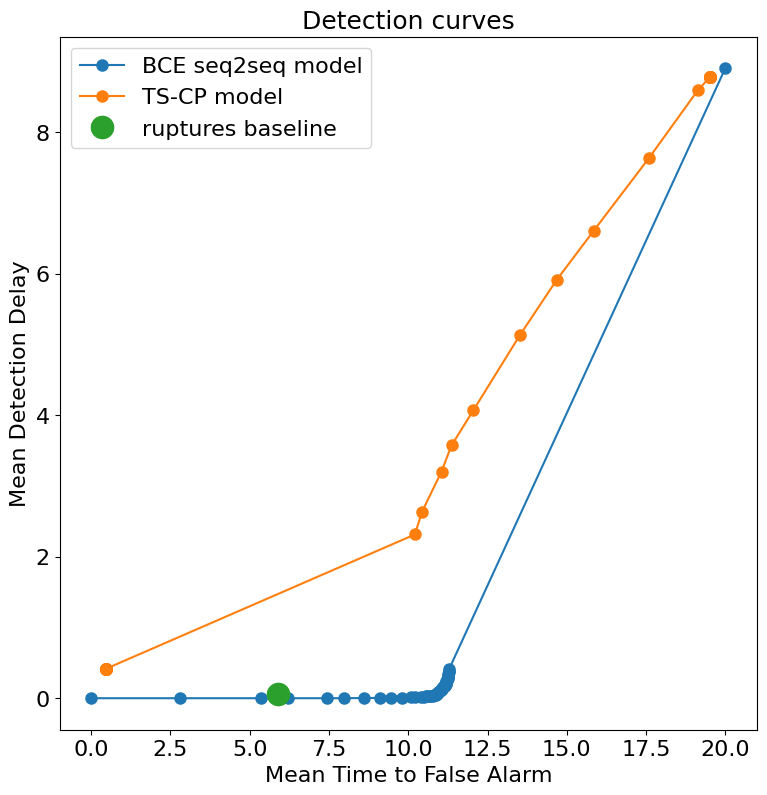

In [48]:
plt.figure(figsize=(9, 9))
plt.plot(fp_delay_list_bce.values(), delay_list_bce.values(), '-o', markersize=8, label="BCE seq2seq model")
plt.plot(fp_delay_list_tscp.values(), delay_list_tscp.values(), '-o', markersize=8, label="TS-CP model")
plt.plot([baseline_fp_delay], [baseline_delay], 'o', markersize=16, label='ruptures baseline')
plt.title("Detection curves", fontsize=18)
plt.xlabel('Mean Time to False Alarm', fontsize=16)
plt.ylabel('Mean Detection Delay', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.show()

## Bonus part: audio segmentation with ruptures

In [ ]:
# !pip install librosa

In [9]:
import librosa
import librosa.display

from IPython.display import Audio, display

In [11]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

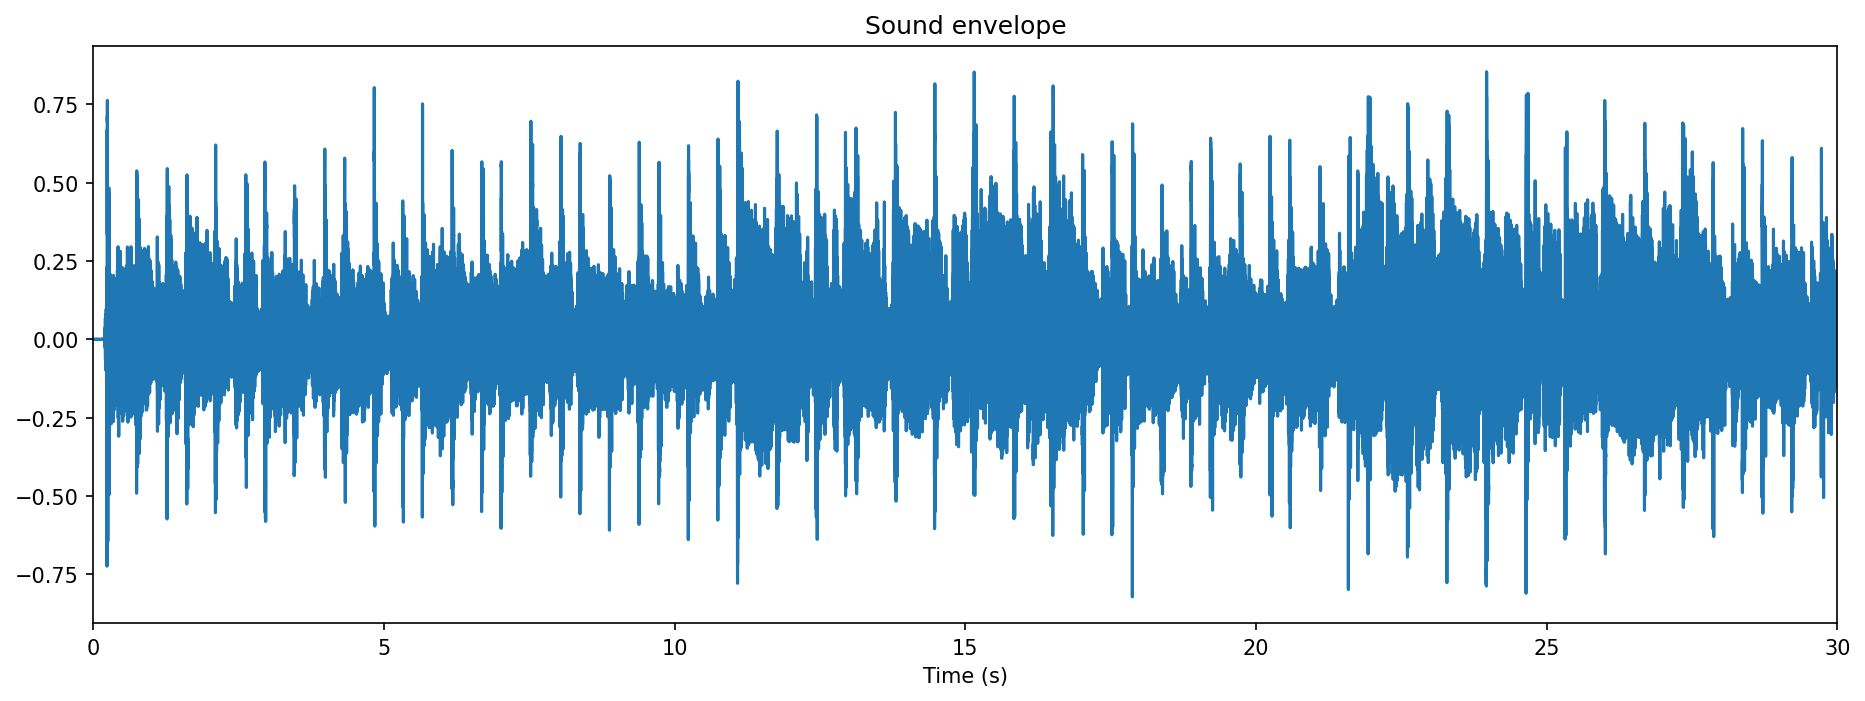

In [22]:
duration = 30  # in seconds
signal, sampling_rate = librosa.load(librosa.ex("fishin"), duration=duration)

# listen to the music
display(Audio(data=signal, rate=sampling_rate))

# look at the envelope
fig, ax = fig_ax()
ax.plot(np.arange(signal.size) / sampling_rate, signal)
ax.set_xlim(0, signal.size / sampling_rate)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

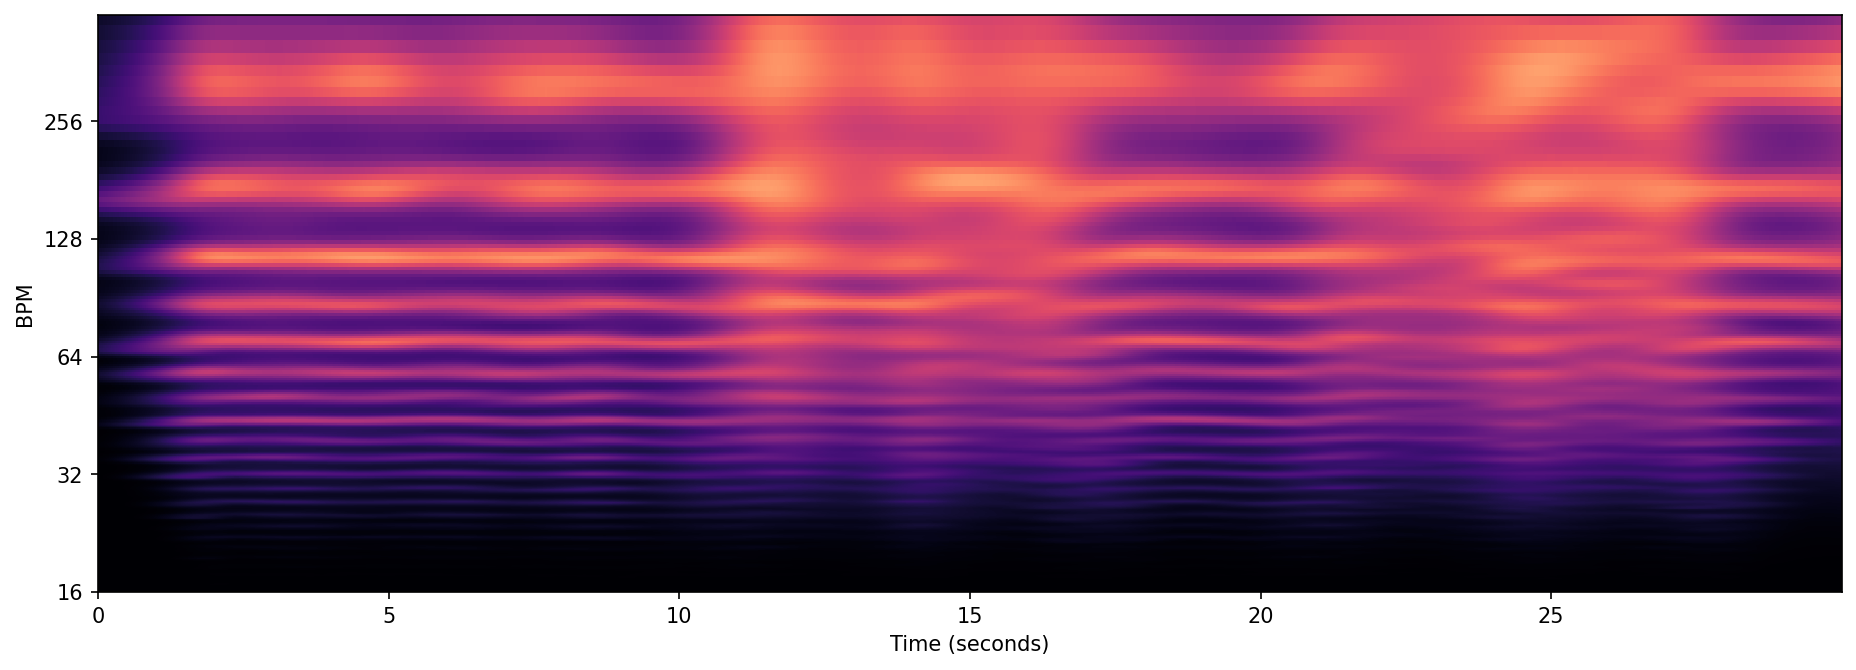

In [23]:
# Compute the onset strength
hop_length_tempo = 256
oenv = librosa.onset.onset_strength(
    y=signal, sr=sampling_rate, hop_length=hop_length_tempo
)
# Compute the tempogram
tempogram = librosa.feature.tempogram(
    onset_envelope=oenv,
    sr=sampling_rate,
    hop_length=hop_length_tempo,
)
# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sampling_rate,
    x_axis="s",
    y_axis="tempo",
)

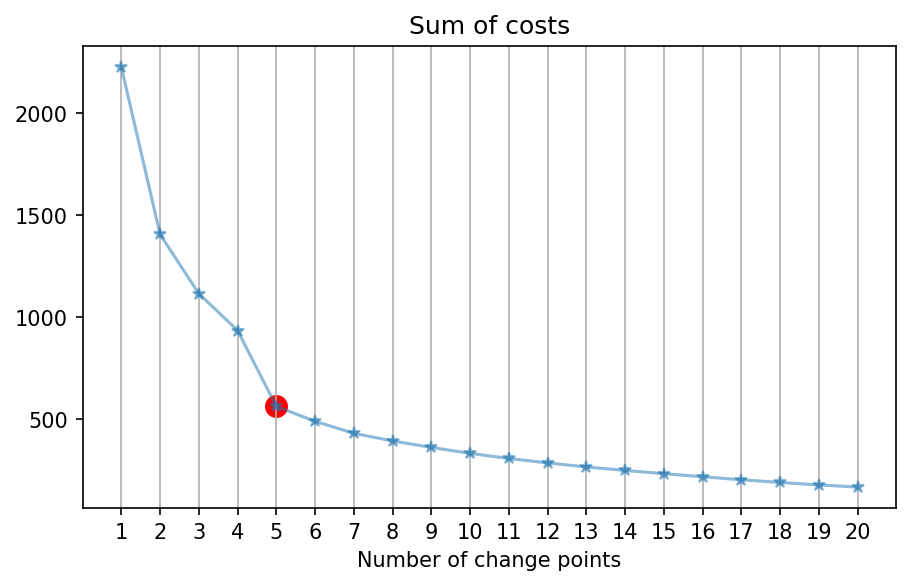

In [24]:
# Choose detection method
algo = rpt.KernelCPD(kernel="linear").fit(tempogram.T)

# Choose the number of changes (elbow heuristic)
n_bkps_max = 20  # K_max
# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
_ = algo.predict(n_bkps_max)

array_of_n_bkps = np.arange(1, n_bkps_max + 1)


def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)


fig, ax = fig_ax((7, 4))
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Number of change points")
ax.set_title("Sum of costs")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

# Visually we choose n_bkps=5 (highlighted in red on the elbow plot)
n_bkps = 6
_ = ax.scatter([5], [get_sum_of_cost(algo=algo, n_bkps=5)], color="r", s=100)


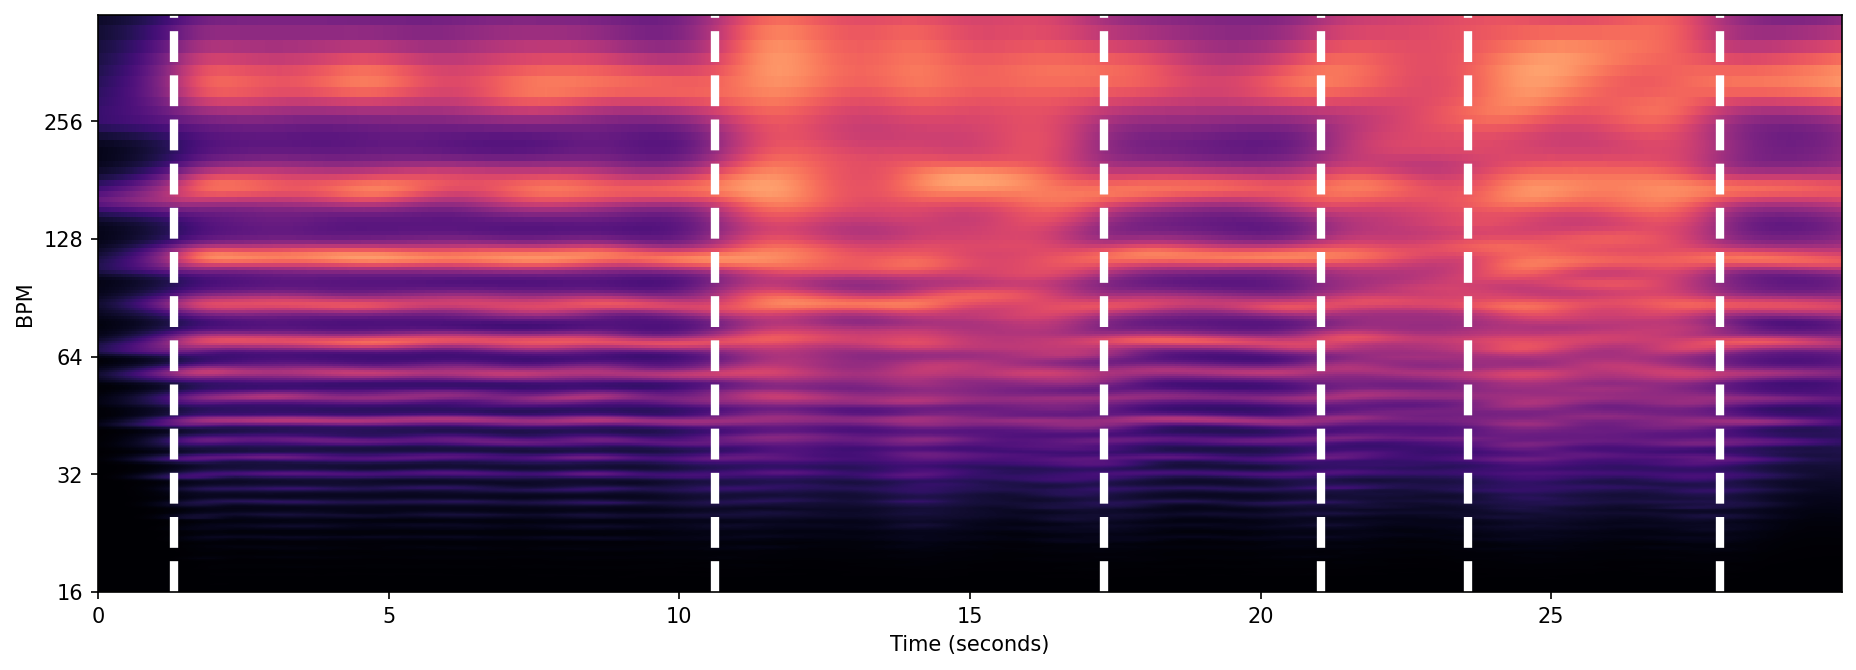

In [25]:
# Segmentation
bkps = algo.predict(n_bkps=n_bkps)
# Convert the estimated change points (frame counts) to actual timestamps
bkps_times = librosa.frames_to_time(bkps, sr=sampling_rate, hop_length=hop_length_tempo)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sampling_rate,
)

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)


In [26]:
# Compute change points corresponding indexes in original signal
bkps_time_indexes = (sampling_rate * bkps_times).astype(int).tolist()

for (segment_number, (start, end)) in enumerate(
    rpt.utils.pairwise([0] + bkps_time_indexes), start=1
):
    segment = signal[start:end]
    print(f"Segment n°{segment_number} (duration: {segment.size/sampling_rate:.2f} s)")
    display(Audio(data=segment, rate=sampling_rate))


Segment n°1 (duration: 1.30 s)


Segment n°2 (duration: 9.31 s)


Segment n°3 (duration: 6.70 s)


Segment n°4 (duration: 3.73 s)


Segment n°5 (duration: 2.53 s)


Segment n°6 (duration: 4.33 s)


Segment n°7 (duration: 2.10 s)
